In [1]:
import torch
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn

import VAE
import VAE_MINST

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE

In [22]:
X, y = make_moons(n_samples=1000, noise=0.1)
X = StandardScaler().fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32)

In [30]:
def loss_2D(recon_x, x, mu, logvar, beta=1):
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")
    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl


model = VAE.VAE(latent_dim=2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 100
batch_size = 128

for epoch in range(epochs):
    model.train()
    perm = torch.randperm(X_tensor.size(0))
    train_loss = 0
    for i in range(0, X_tensor.size(0), batch_size):
        indices = perm[i : i + batch_size]
        batch = X_tensor[indices]
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss = loss_2D(recon, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {train_loss / len(X_tensor):.4f}")

Epoch 10, Loss: 1.8136
Epoch 20, Loss: 1.6650
Epoch 30, Loss: 1.6109
Epoch 40, Loss: 1.6043
Epoch 50, Loss: 1.5837
Epoch 60, Loss: 1.5744
Epoch 70, Loss: 1.5447
Epoch 80, Loss: 1.5503
Epoch 90, Loss: 1.5301
Epoch 100, Loss: 1.5497


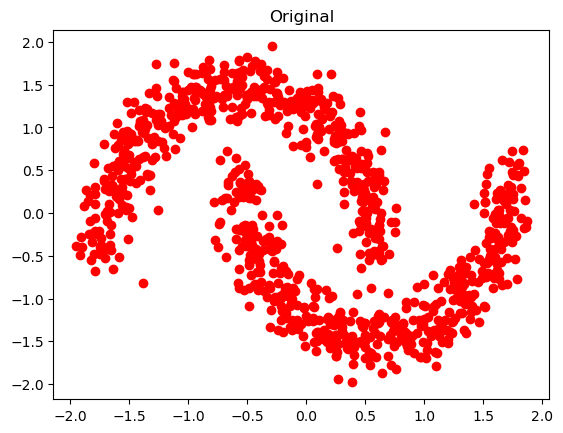

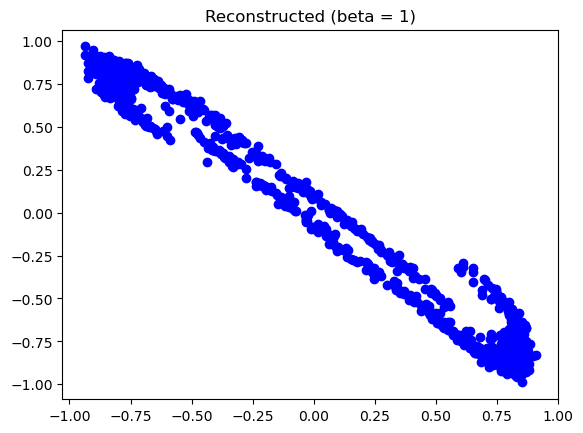

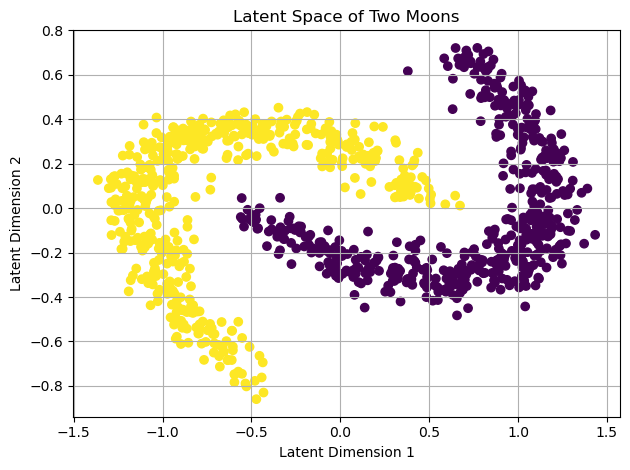

In [31]:
model.eval()
with torch.no_grad():
    mu, _ = model.encode(X_tensor)
    recon = model.decode(mu)
    mu = mu.numpy()
    recon = recon.numpy()

# Plot original vs. reconstructed
plt.title("Original")
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], color="red")
plt.show()

plt.title("Reconstructed (beta = 1)")
plt.scatter(recon[:, 0], recon[:, 1], color="blue")
plt.show()

plt.scatter(mu[:, 0], mu[:, 1], c=y)
plt.title("Latent Space of Two Moons")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 10, Loss: 1.7583
Epoch 20, Loss: 0.6412
Epoch 30, Loss: 0.1577
Epoch 40, Loss: 0.1074
Epoch 50, Loss: 0.0962
Epoch 60, Loss: 0.0863
Epoch 70, Loss: 0.0813
Epoch 80, Loss: 0.0771
Epoch 90, Loss: 0.0723
Epoch 100, Loss: 0.0720


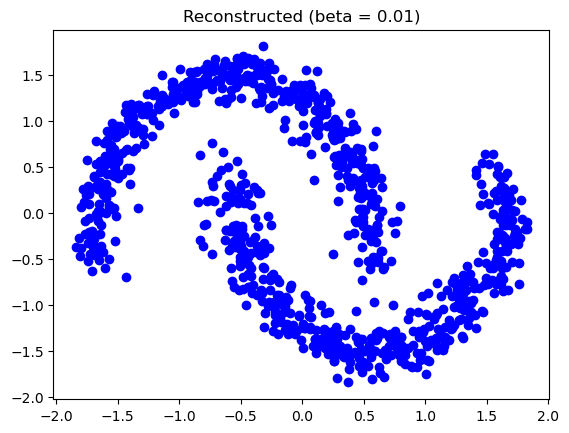

In [28]:
model = VAE.VAE(latent_dim=2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 100
batch_size = 128

for epoch in range(epochs):
    model.train()
    perm = torch.randperm(X_tensor.size(0))
    train_loss = 0
    for i in range(0, X_tensor.size(0), batch_size):
        indices = perm[i : i + batch_size]
        batch = X_tensor[indices]
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss = loss_2D(recon, batch, mu, logvar, beta=0.01)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {train_loss / len(X_tensor):.4f}")

model.eval()
with torch.no_grad():
    mu, _ = model.encode(X_tensor)
    recon = model.decode(mu)
    mu = mu.numpy()
    recon = recon.numpy()

plt.title("Reconstructed (beta = 0.01)")
plt.scatter(recon[:, 0], recon[:, 1], color="blue")
plt.show()

In [2]:
# Load MNIST
transform = transforms.ToTensor()
train_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_data = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [20]:
def loss_MINST(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


model2 = VAE_MINST.VAE(latent=20)
optimizer = optim.Adam(model2.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    model2.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon, mu, logvar = model2(data)
        loss = loss_MINST(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 165.8268
Epoch 2, Loss: 121.4688
Epoch 3, Loss: 114.4895
Epoch 4, Loss: 111.5504
Epoch 5, Loss: 109.8317
Epoch 6, Loss: 108.7302
Epoch 7, Loss: 107.8470
Epoch 8, Loss: 107.2186
Epoch 9, Loss: 106.7229
Epoch 10, Loss: 106.3092


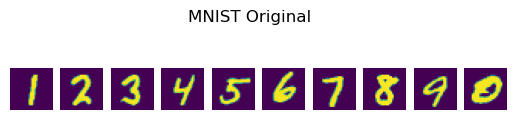

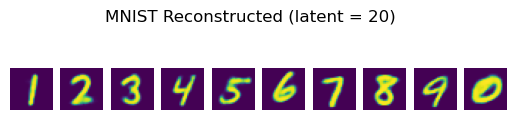

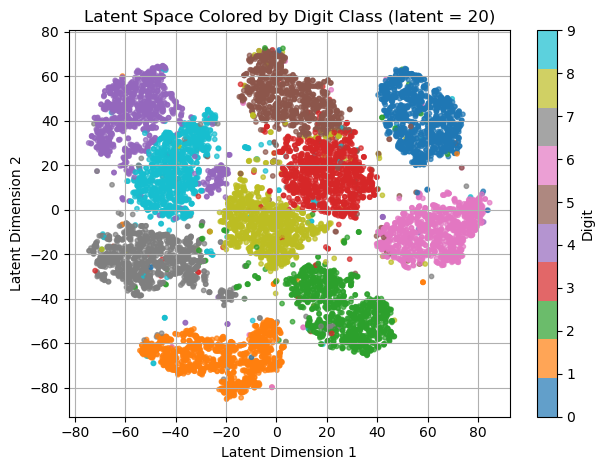

In [34]:
model2.eval()
latents = []
labels = []
with torch.no_grad():
    for batch, y in test_loader:
        batch = batch.view(-1, 784)
        mu, _ = model2.encode(batch)
        recon = model2.decode(mu)
        latents.append(mu)
        labels.append(y)

n = 10
for i in range(n):
    # Original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(batch[i].view(28, 28).detach().numpy())
    plt.axis("off")

plt.suptitle("MNIST Original")
plt.show()

n = 10
for i in range(n):
    # Reconstruction
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(recon[i].view(28, 28).detach().numpy())
    plt.axis("off")
plt.suptitle("MNIST Reconstructed (latent = 20)")
plt.show()

latents = torch.cat(latents).detach().numpy()
labels = torch.cat(labels).detach().numpy()

# If latent_dim > 2, reduce to 2D using t-SNE
if latents.shape[1] > 2:
    latents = TSNE(n_components=2, random_state=42).fit_transform(latents)

scatter = plt.scatter(
    latents[:, 0], latents[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7
)
plt.colorbar(scatter, ticks=range(10), label="Digit")
plt.title("Latent Space Colored by Digit Class (latent = 20)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
model2 = VAE_MINST.VAE(latent=2)
optimizer = optim.Adam(model2.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    model2.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon, mu, logvar = model2(data)
        loss = loss_MINST(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 190.0197
Epoch 2, Loss: 166.9062
Epoch 3, Loss: 163.0386
Epoch 4, Loss: 160.6791
Epoch 5, Loss: 159.0941
Epoch 6, Loss: 157.8770
Epoch 7, Loss: 156.9229
Epoch 8, Loss: 156.0174
Epoch 9, Loss: 155.2426
Epoch 10, Loss: 154.5873


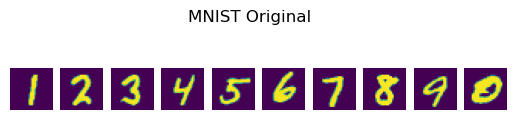

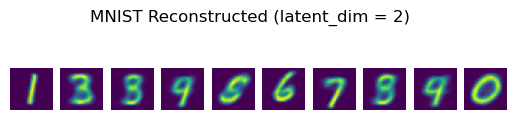

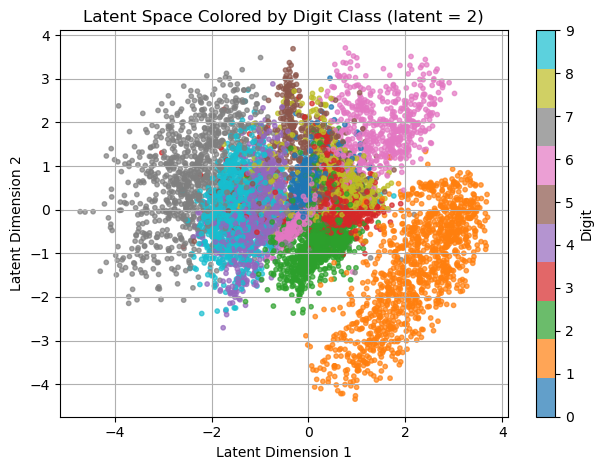

In [ ]:
model2.eval()
latents = []
labels = []
with torch.no_grad():
    for batch, y in test_loader:
        batch = batch.view(-1, 784)
        mu, _ = model2.encode(batch)
        recon = model2.decode(mu)
        latents.append(mu)
        labels.append(y)

n = 10
for i in range(n):
    # Original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(batch[i].view(28, 28).detach().numpy())
    plt.axis("off")

plt.suptitle("MNIST Original")
plt.show()

n = 10
for i in range(n):
    # Reconstruction
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(recon[i].view(28, 28).detach().numpy())
    plt.axis("off")
plt.suptitle("MNIST Reconstructed (latent_dim = 2)")
plt.show()

latents = torch.cat(latents).detach().numpy()
labels = torch.cat(labels).detach().numpy()

# If latent_dim > 2, reduce to 2D using t-SNE
if latents.shape[1] > 2:
    latents = TSNE(n_components=2, random_state=42).fit_transform(latents)

scatter = plt.scatter(
    latents[:, 0], latents[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7
)
plt.colorbar(scatter, ticks=range(10), label="Digit")
plt.title("Latent Space Colored by Digit Class (latent = 2)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
def loss_MINST_MSE(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, 28 * 28), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


model3 = VAE_MINST.VAE(latent=20)
optimizer = optim.Adam(model3.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    model3.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()

        recon, mu, logvar = model3(data)
        loss = loss_MINST_MSE(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 45.3027
Epoch 2, Loss: 34.9023
Epoch 3, Loss: 33.0773
Epoch 4, Loss: 32.2000
Epoch 5, Loss: 31.7122
Epoch 6, Loss: 31.3412
Epoch 7, Loss: 31.0907
Epoch 8, Loss: 30.9172
Epoch 9, Loss: 30.7110
Epoch 10, Loss: 30.6086


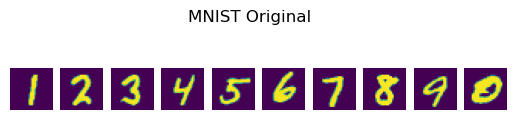

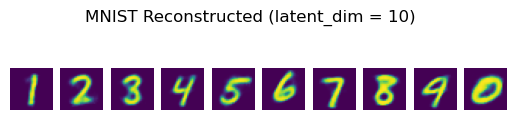

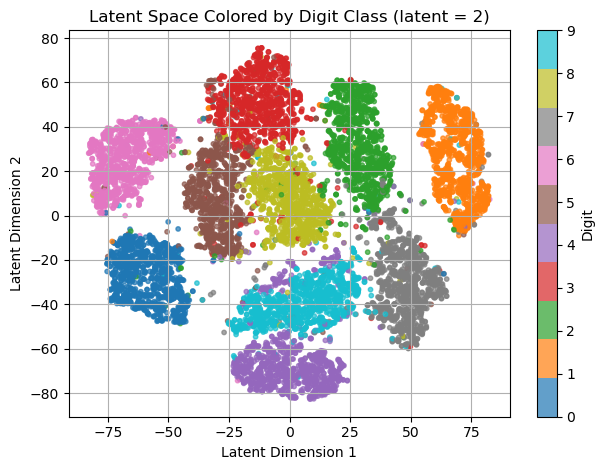

In [ ]:
model3.eval()
latents = []
labels = []
with torch.no_grad():
    for batch, y in test_loader:
        batch = batch.view(-1, 784)
        mu, _ = model3.encode(batch)
        recon = model3.decode(mu)
        latents.append(mu)
        labels.append(y)

n = 10
for i in range(n):
    # Original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(batch[i].view(28, 28).detach().numpy())
    plt.axis("off")

plt.suptitle("MNIST Original")
plt.show()

n = 10
for i in range(n):
    # Reconstruction
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(recon[i].view(28, 28).detach().numpy())
    plt.axis("off")
plt.suptitle("MNIST Reconstructed (latent_dim = 20, MSE)")
plt.show()

latents = torch.cat(latents).detach().numpy()
labels = torch.cat(labels).detach().numpy()

# If latent_dim > 2, reduce to 2D using t-SNE
if latents.shape[1] > 2:
    latents = TSNE(n_components=2, random_state=42).fit_transform(latents)

scatter = plt.scatter(
    latents[:, 0], latents[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7
)
plt.colorbar(scatter, ticks=range(10), label="Digit")
plt.title("Latent Space Colored by Digit Class (latent = 20, MSE)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model3 = VAE_MINST.VAE(latent=2)
optimizer = optim.Adam(model3.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    model3.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()

        recon, mu, logvar = model3(data)
        loss = loss_MINST_MSE(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 49.2300
Epoch 2, Loss: 42.6418
Epoch 3, Loss: 41.6331
Epoch 4, Loss: 41.0752


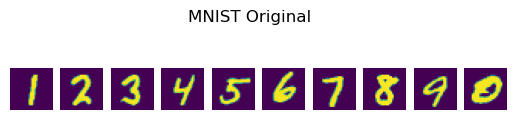

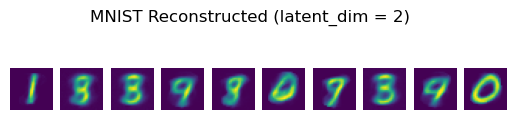

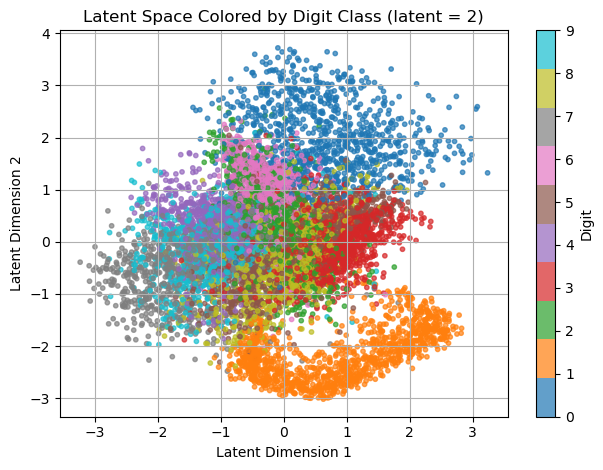

In [ ]:
model3.eval()
latents = []
labels = []
with torch.no_grad():
    for batch, y in test_loader:
        batch = batch.view(-1, 784)
        mu, _ = model3.encode(batch)
        recon = model3.decode(mu)
        latents.append(mu)
        labels.append(y)

n = 10
for i in range(n):
    # Original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(batch[i].view(28, 28).detach().numpy())
    plt.axis("off")

plt.suptitle("MNIST Original")
plt.show()

n = 10
for i in range(n):
    # Reconstruction
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(recon[i].view(28, 28).detach().numpy())
    plt.axis("off")
plt.suptitle("MNIST Reconstructed (latent_dim = 2, MSE)")
plt.show()

latents = torch.cat(latents).detach().numpy()
labels = torch.cat(labels).detach().numpy()

# If latent_dim > 2, reduce to 2D using t-SNE
if latents.shape[1] > 2:
    latents = TSNE(n_components=2, random_state=42).fit_transform(latents)

scatter = plt.scatter(
    latents[:, 0], latents[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7
)
plt.colorbar(scatter, ticks=range(10), label="Digit")
plt.title("Latent Space Colored by Digit Class (latent = 2, MSE)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()